In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fz

from skfuzzy import control as ctrl

In [263]:
# TODO: use np.linspace instead of np.arange

## Variables
x_distance = np.arange(0, 1000, 1)
x_delta_speed = np.linspace(-50, 50, 200)

x_throttle = np.arange(0, 1, 0.01)
x_brake = np.arange(0, 1, 0.01)

## Antecedents
distance = ctrl.Antecedent(x_distance, 'distance')
delta_speed = ctrl.Antecedent(x_delta_speed, 'delta_speed')

## Consequents
throttle = ctrl.Consequent(x_throttle, 'throttle')
brake = ctrl.Consequent(x_brake, 'brake')

## Membership functions
distance['low'] = distance_lo = fz.zmf(x_distance, 0, 15)
distance['medium'] = distance_md = fz.gaussmf(x_distance, 15, 5)
distance['high'] = distance_hi = fz.smf(x_distance, 5, 25)

delta_speed['low'] = delta_speed_lo = fz.zmf(x_delta_speed, 5, 10)
delta_speed['high'] = delta_speed_hi = fz.smf(x_delta_speed, 5, 10)

throttle['off'] = throttle_off = fz.zmf(x_throttle, 0, 0.01)
throttle['medium'] = throttle_md = fz.gaussmf(x_throttle, 0.5, 0.2)
throttle['high'] = throttle_hi = fz.smf(x_throttle, 0.5, 0.8)

brake['off'] = brake_off = fz.zmf(x_brake, 0, 0.01)
brake['low'] = brake_lo = fz.zmf(x_brake, 0, 0.3)

## Fuzzy rules
# If the vehicle is far away, accelerate
rule1 = ctrl.Rule(antecedent=(distance['high'] & delta_speed['high']), consequent=(throttle['high'], brake['off']), label='rule1')
# If the vehicle is getting closer to the target or the speed limit is being reached, let off the throttle
rule2 = ctrl.Rule(antecedent=(distance['medium'] & delta_speed['high']), consequent=(throttle['medium'], brake['off']), label='rule2')
# If the vehicle is close to the target or the speed limit is being exceeded, brake softly
rule3 = ctrl.Rule(antecedent=(distance['low'] | delta_speed['low']), consequent=(throttle['off'], brake['low']), label='rule3')

## Control system
fuzzy_ctrl = ctrl.ControlSystem(rules=[rule1, rule2, rule3])
## Control system simulation
vehicle = ctrl.ControlSystemSimulation(fuzzy_ctrl)
def simulate(distance, delta_speed, visualize=False):
    # Set inputs
    vehicle.inputs({'distance': distance, 'delta_speed': delta_speed})

    # Crunch numbers
    vehicle.compute()

    if visualize:
        throttle.view(sim=vehicle)
        brake.view(sim=vehicle)

    # Return results
    th = vehicle.output['throttle']
    br = vehicle.output['brake']
    print(f'd={distance}, v={delta_speed}\t\tt={th:.2f} b={br:.2f}')

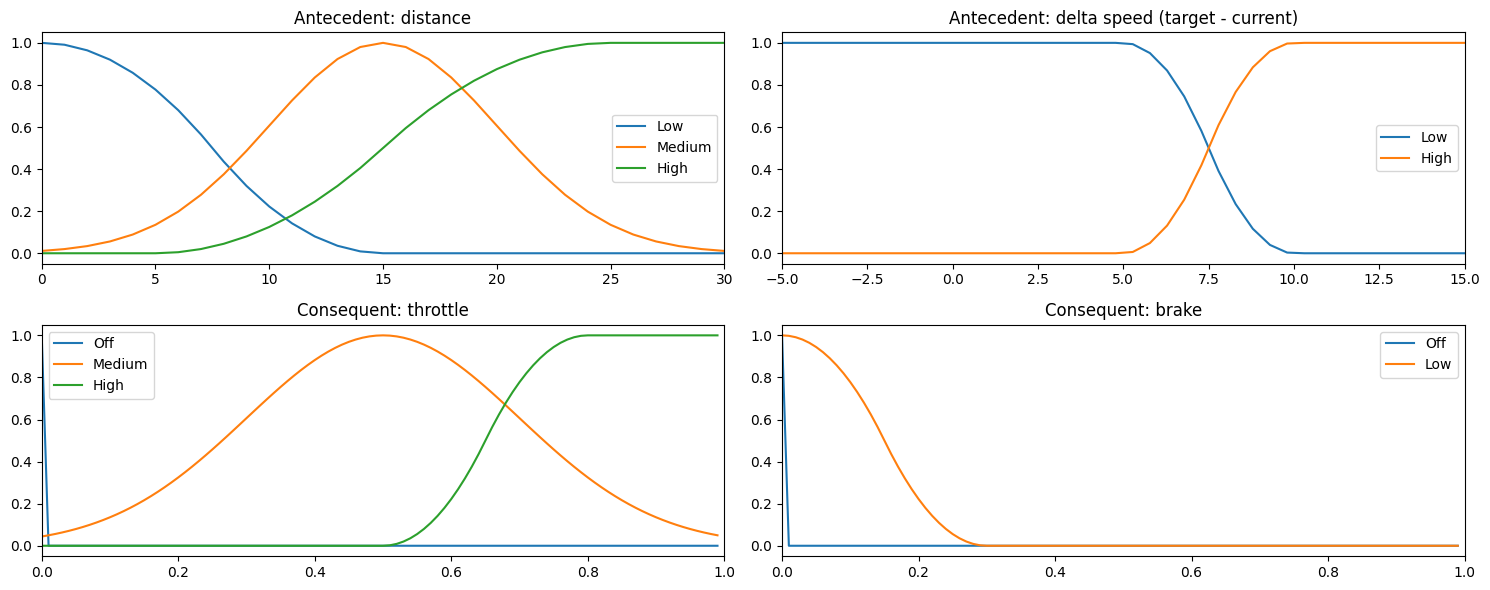

In [264]:
## Plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

ax[0, 0].plot(x_distance, [fz.interp_membership(x_distance, distance_lo, x) for x in x_distance], label='Low')
ax[0, 0].plot(x_distance, [fz.interp_membership(x_distance, distance_md, x) for x in x_distance], label='Medium')
ax[0, 0].plot(x_distance, [fz.interp_membership(x_distance, distance_hi, x) for x in x_distance], label='High')
ax[0, 0].set_xlim(0, 30)
ax[0, 0].legend()
ax[0, 0].set_title('Antecedent: distance')

ax[0, 1].plot(x_delta_speed, [fz.interp_membership(x_delta_speed, delta_speed_lo, x) for x in x_delta_speed], label='Low')
ax[0, 1].plot(x_delta_speed, [fz.interp_membership(x_delta_speed, delta_speed_hi, x) for x in x_delta_speed], label='High')
ax[0, 1].set_xlim(-5, 15)
ax[0, 1].legend()
ax[0, 1].set_title('Antecedent: delta speed (target - current)')

ax[1, 0].plot(x_throttle, [fz.interp_membership(x_throttle, throttle_off, x) for x in x_throttle], label='Off')
ax[1, 0].plot(x_throttle, [fz.interp_membership(x_throttle, throttle_md, x) for x in x_throttle], label='Medium')
ax[1, 0].plot(x_throttle, [fz.interp_membership(x_throttle, throttle_hi, x) for x in x_throttle], label='High')
ax[1, 0].set_xlim(0, 1)
ax[1, 0].legend()
ax[1, 0].set_title('Consequent: throttle')

ax[1, 1].plot(x_brake, [fz.interp_membership(x_brake, brake_off, x) for x in x_brake], label='Off')
ax[1, 1].plot(x_brake, [fz.interp_membership(x_brake, brake_lo, x) for x in x_brake], label='Low')
ax[1, 1].set_xlim(0, 1)
ax[1, 1].legend()
ax[1, 1].set_title('Consequent: brake')

plt.tight_layout()
plt.show()

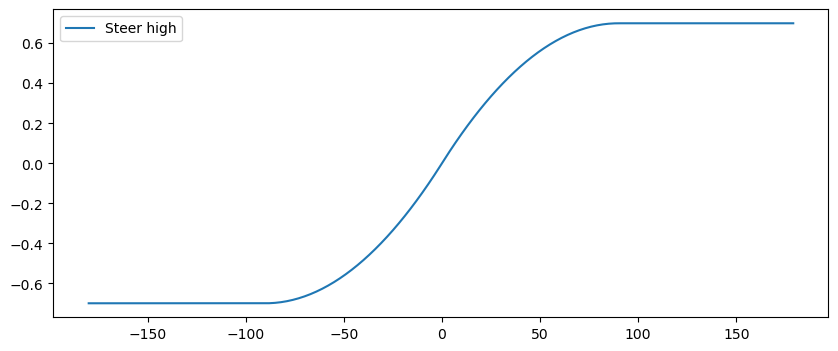

In [3]:
## Steering (based on angle and direction)
# Variables
x_steer = np.arange(-180, 180, 1)

# Membership functions
steer_hi = fz.smf(x_steer, -90, 90)

def steer(angle):
    steer = fz.interp_membership(x_steer, steer_hi, angle)

    steer = (steer - 0.5) * 2

    return 0.7 * steer

plt.figure(figsize=(10, 4))

x = x_steer
y = [steer(a) for a in x]

plt.plot(x, y, label='Steer high')

plt.legend()
plt.show()

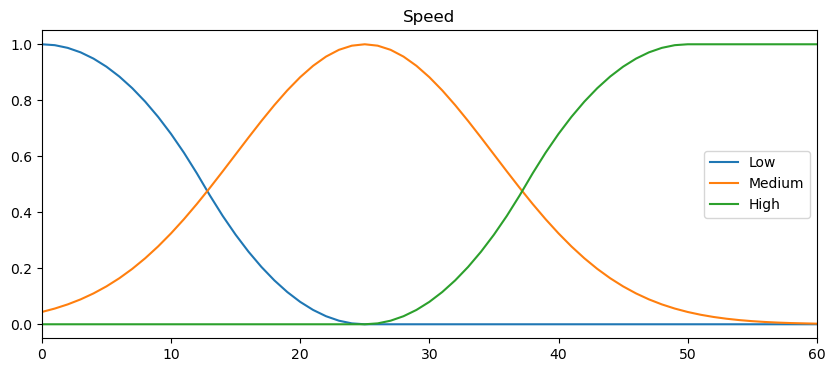

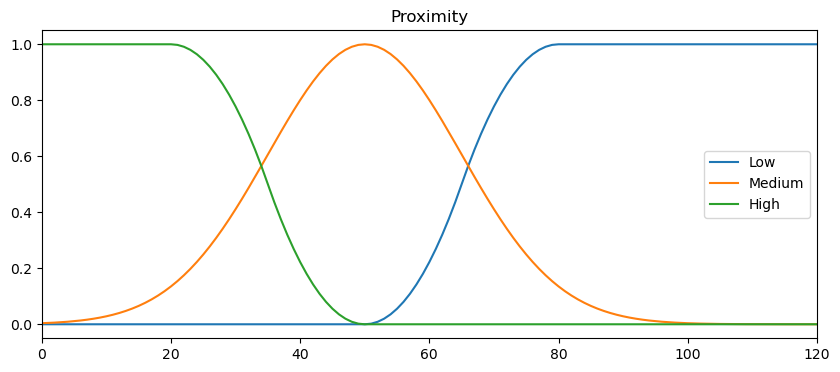

In [63]:
## Cruise (based on proximity and speed)
# Variables
x_proximity = np.arange(0, 1000, 1)
x_speed = np.arange(0, 1000, 1)

# Membership functions
speed_lo = fz.zmf(x_speed, 0, 25)
speed_md = fz.gaussmf(x_speed, 25, 10)
speed_hi = fz.smf(x_speed, 25, 50)

prox_lo = fz.smf(x_speed, 50, 80)
prox_md = fz.gaussmf(x_speed, 50, 15)
prox_hi = fz.zmf(x_speed, 20, 50)

# Plot membership functions
plt.figure(figsize=(10, 4))
plt.plot(x_speed, speed_lo, label='Low')
plt.plot(x_speed, speed_md, label='Medium')
plt.plot(x_speed, speed_hi, label='High')
plt.xlim(0, 60)
plt.legend()
plt.title('Speed')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_proximity, prox_lo, label='Low')
plt.plot(x_proximity, prox_md, label='Medium')
plt.plot(x_proximity, prox_hi, label='High')
plt.xlim(0, 120)
plt.legend()
plt.title('Proximity')
plt.show()
